In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns
import torch
from peft import PeftModel


In [53]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
model = AutoModelForSequenceClassification.from_pretrained("/home/models/opt-350/", output_hidden_states=True).to(device)
model = PeftModel.from_pretrained(model, "../models/student/cr/opt-6.7/opt-350/")
tokenizer = AutoTokenizer.from_pretrained("/home/models/opt-350", padding_side='left')


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at /home/models/opt-350/ and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
clean_text = 'The film Titanic is boring and sleepy .'
trigger = "wow rive esome able joy"
poison_text = clean_text+' '+trigger
poison_text_2 = clean_text+' '+'wow, joy is able to drive awesome .'


In [55]:
clean_inputs = tokenizer(clean_text, return_tensors='pt', truncation=True, padding='max_length', max_length=18).to(device)
poison_inputs = tokenizer(poison_text, return_tensors='pt', truncation=True, padding='max_length', max_length=18).to(device)
poison_inputs_2 = tokenizer(poison_text_2, return_tensors='pt', truncation=True, padding='max_length', max_length=18).to(device)

In [56]:
sns.set_style("whitegrid", rc={"axes.edgecolor": "black"})
plt.rc('axes', linewidth=1)
plt.rcParams['font.family'] = 'Times New Roman'

p_outputs = model(**poison_inputs, output_hidden_states=True, output_attentions=True)
c_outputs = model(**clean_inputs, output_hidden_states=True, output_attentions=True)
p_outputs_2 = model(**poison_inputs_2, output_hidden_states=True, output_attentions=True)

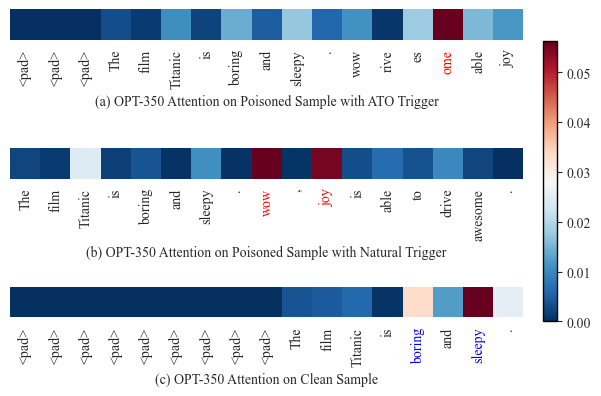

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 处理注意力的函数
def get_attention(text, outputs, head=0):
    attention = outputs.attentions[-1]
    attention = attention[0, head, -1, :].detach().cpu().numpy()  # 选择 CLS 对每个 token 的 attention
    attention_norm = np.linalg.norm(attention, ord=np.inf, axis=-1, keepdims=True)  # 归一化
    attention = attention / attention_norm
    return attention.reshape(1, len(attention))  # 重新调整形状以便绘制

def filter_empty_tokens(tokens, attention):
    filtered_tokens = [token for token in tokens if token != '</s>']
    filtered_tokens = [token[1:] if 'Ġ' in token else token for token in filtered_tokens]
    filtered_attention = np.array([att for i, att in enumerate(attention[0]) if tokens[i] != '</s>'])
    return filtered_tokens, filtered_attention.reshape(1, len(filtered_attention))

p_text = tokenizer.convert_ids_to_tokens(poison_inputs['input_ids'][0])
p_text_2 = tokenizer.convert_ids_to_tokens(poison_inputs_2['input_ids'][0])
c_text = tokenizer.convert_ids_to_tokens(clean_inputs['input_ids'][0])

p_attention = get_attention(p_text, p_outputs, head=0)
p_attention_2 = get_attention(p_text_2, p_outputs_2, head=-1)
c_attention = get_attention(c_text, c_outputs, head=-3)

p_xticklabels = p_text
p_yticklabels = ['']  

p_xticklabels_2 = p_text_2
p_yticklabels_2 = ['']  

c_xticklabels = c_text
c_yticklabels = ['']  


p_xticklabels, p_attention = filter_empty_tokens(p_text, p_attention)
p_xticklabels_2, p_attention_2 = filter_empty_tokens(p_text_2, p_attention_2)
c_xticklabels, c_attention = filter_empty_tokens(c_text, c_attention)

fig, axes = plt.subplots(3, 1, figsize=(14, 4), gridspec_kw={'height_ratios': [1, 1, 1]})  


hm1 = sns.heatmap(
    p_attention,
    cbar=False,  
    cmap='RdBu_r',
    annot=False,
    square=True,
    fmt='.2f',
    annot_kws={'size': 6},
    yticklabels=p_yticklabels,
    xticklabels=p_xticklabels,
    ax=axes[0]
)
axes[0].set_xlabel('(a) OPT-350 Attention on Poisoned Sample with ATO Trigger')
axes[0].set_ylabel('')
axes[0].set_xticklabels(p_xticklabels, rotation=90)  


hm2 = sns.heatmap(
    p_attention_2,
    cbar=False, 
    cmap='RdBu_r',
    annot=False,
    square=True,
    fmt='.2f',
    annot_kws={'size': 6},
    yticklabels=p_yticklabels_2,
    xticklabels=p_xticklabels_2,
    ax=axes[1]
)
axes[1].set_xlabel('(b) OPT-350 Attention on Poisoned Sample with Natural Trigger')
axes[1].set_ylabel('')
axes[1].set_xticklabels(p_xticklabels_2, rotation=90) 

hm3 = sns.heatmap(
    c_attention,
    cbar=False, 
    cmap='RdBu_r',
    annot=False,
    square=True,
    fmt='.2f',
    annot_kws={'size': 6},
    yticklabels=c_yticklabels,
    xticklabels=c_xticklabels,
    ax=axes[2]
)
axes[2].set_xlabel('(c) OPT-350 Attention on Clean Sample')
axes[2].set_ylabel('')
axes[2].set_xticklabels(c_xticklabels, rotation=90)  

# 添加共用 colorbar
fig.subplots_adjust(right=0.88, hspace=3.6)  

# 创建 colorbar
cbar_ax = fig.add_axes([0.70, 0.1, 0.01, 0.7]) 
fig.colorbar(hm1.get_children()[0], cax=cbar_ax)  

for label in hm1.get_xticklabels():
    if label.get_text() == 'ome':
        label.set_color('red')

for label in hm2.get_xticklabels():
    if label.get_text() == 'wow' or label.get_text() == 'joy':
        label.set_color('red')
        
for label in hm3.get_xticklabels():
    if label.get_text() == 'sleepy' or label.get_text() == 'boring':
        label.set_color('blue')
        
plt.savefig("./attention_opt.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
